<h1>LightGBM Models Training</h1>
<h3>WIDS 2024 Challenge ++</h3>
<h3>BMI 212 - Team DMMTS</h3>

In [71]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn import preprocessing
pd.set_option("mode.copy_on_write", True)

<h4> Load the data</h4>

In [72]:
# Load the CSV dataset
data_df = pd.read_csv('./Data/train_test_added_climate_data.csv')

# Rename feature columns for better readability
data_df.rename(columns={'bmi': 'patient_bmi',
                   'region': 'patient_region',
                   'division': 'patient_division',
                   'side': 'patient_tumor_side',
                   'quadrant': 'patient_tumor_quadrant',
                   'metastatic_organ': 'patient_metastatic_organ',
                   'cleaned_metastatic_first_treatment': 'patient_metastatic_first_treatment',
                   'cleaned_metastatic_first_treatment_type': 'patient_metastatic_first_treatment_type',
                   'population': 'population_size',
                   'density': 'population_density',
                   'age_median': 'population_age_median',
                   'female': 'population_female_perc',
                   'married': 'population_married_perc',
                   'divorced': 'population_divorced_perc',
                   'never_married': 'population_never_married_perc',
                   'widowed': 'population_widowed_perc',
                   'family_size': 'population_family_size',
                   'family_dual_income': 'population_family_dual_income_perc',
                   'income_individual_median': 'population_income_individual_median',
                   'income_household_median': 'population_income_household_median',
                   'home_ownership': 'population_home_ownership_perc',
                   'home_value': 'population_home_value',
                   'rent_median': 'population_rent_median',
                   'rent_burden': 'population_rent_burden_perc',
                   'education_less_highschool': 'population_education_less_highschool_perc',
                   'education_highschool': 'population_education_highschool_perc',
                   'education_some_college': 'population_education_some_college_perc',
                   'education_bachelors': 'population_education_bachelors_perc',
                   'education_graduate': 'population_education_graduate_perc',
                   'education_college_or_above': 'population_education_college_or_above_perc',
                   'education_stem_degree': 'population_education_stem_degree_perc',
                   'unemployment_rate': 'population_unemployment_rate',
                   'self_employed': 'population_self_employed_perc',
                   'farmer': 'population_farmer_perc',
                   'race_white': 'population_race_white_perc',
                   'race_black': 'population_race_black_perc',
                   'race_asian': 'population_race_asian_perc',
                   'race_native': 'population_race_native_american_perc',
                   'race_pacific': 'population_race_pacific_islander_perc',
                   'race_other': 'population_race_other_perc',
                   'race_multiple': 'population_race_multiple_perc',
                   'hispanic': 'population_hispanic_perc',
                   'disabled': 'population_disabled_perc',
                   'poverty': 'population_poverty_perc',
                   'limited_english': 'population_limited_english_perc',
                   'commute_time': 'population_commute_time',
                   'health_uninsured': 'population_health_uninsured_perc',
                   'veteran': 'population_veteran_perc',
                    'Ozone': 'annual_ozone_conc',
                    'PM25': 'annual_fine_particulate_matter_conc',
                    'N02': 'annual_nitrogen_dioxide_conc'
                        
                   }, inplace=True)

<h4>Select the features to use</h4>

In [73]:
features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'patient_gender', 'patient_bmi',
            'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant',
            'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type',
            'population_size', 'population_density', 'population_age_median', 'population_female_perc',
            'population_married_perc', 'population_divorced_perc', 'population_never_married_perc',
            'population_widowed_perc', 'population_family_size', 'population_family_dual_income_perc',
            'population_income_individual_median', 'population_income_household_median', 'population_home_ownership_perc',
            'population_home_value', 'population_rent_median', 'population_rent_burden_perc',
            'population_education_less_highschool_perc', 'population_education_highschool_perc',
            'population_education_some_college_perc', 'population_education_bachelors_perc',
            'population_education_graduate_perc', 'population_education_college_or_above_perc',
            'population_education_stem_degree_perc', 'population_unemployment_rate', 'population_self_employed_perc',
            'population_farmer_perc', 'population_race_white_perc', 'population_race_black_perc',
            'population_race_asian_perc', 'population_race_native_american_perc', 'population_race_pacific_islander_perc',
            'population_race_other_perc', 'population_race_multiple_perc', 'population_hispanic_perc',
            'population_disabled_perc', 'population_poverty_perc', 'population_limited_english_perc',
            'population_commute_time', 'population_health_uninsured_perc', 'population_veteran_perc', 'annual_nitrogen_dioxide_conc',
            'annual_fine_particulate_matter_conc', 'annual_ozone_conc']

# Select only rows where allocated_set is train
train_df = data_df[data_df['allocated_set'] == 'train']
train_df.head()

# Select the features to use
features_df = train_df[features]

# Extract labels for time to treatment 
labels_df = train_df[['treatment_pd']]

# Split into train/test 80/20

In [74]:
# Convert object features to categorical
for col in features_df.select_dtypes(include='object').columns:
    features_df[col] = features_df[col].astype('category')

# List of categorical features
categorical_features = list(features_df.select_dtypes(include='category').columns)

# Rename dfs of features and target
X = features_df
y = labels_df

<h4>30-days labels</h4>

In [75]:
# Create labels for >30 days time to treatment
labels_30 = labels_df.copy()
labels_30.loc[labels_30['treatment_pd'] > 30, 'label'] = 1 
labels_30.loc[labels_30['treatment_pd'] <= 30, 'label'] = 0 
labels_30.head()

,treatment_pd,label
0,35.0,1.0
1,33.0,1.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [76]:
y_30 = labels_30[['label']]

# Split the data into train/test split (80/20)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X, y_30, test_size=0.2, random_state=123)

<h4>60-days labels</h4>

In [77]:
# Create labels for >30 days time to treatment
labels_60 = labels_df.copy()
labels_60.loc[labels_60['treatment_pd'] > 60, 'label'] = 1 
labels_60.loc[labels_60['treatment_pd'] <= 60, 'label'] = 0 
labels_60.head()

,treatment_pd,label
0,35.0,0.0
1,33.0,0.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [78]:
y_60 = labels_60[['label']]

# Split the data into train/test split (80/20)
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X, y_60, test_size=0.2, random_state=123)

<h4>90-days labels</h4>

In [79]:
# Create labels for >30 days time to treatment
labels_90 = labels_df.copy()
labels_90.loc[labels_90['treatment_pd'] > 90, 'label'] = 1 
labels_90.loc[labels_90['treatment_pd'] <= 90, 'label'] = 0 
labels_90.head()

,treatment_pd,label
0,35.0,0.0
1,33.0,0.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [80]:
y_90 = labels_90[['label']]

# Split the data into train/test split (80/20)
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X, y_90, test_size=0.2, random_state=123)

In [81]:
print(categorical_features)

['patient_race', 'payer_type', 'patient_state', 'patient_gender', 'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant', 'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type']


# Prep LightGBM dataset

<h4>30-day classification</h4>

In [82]:
# Create the LightGBM dataset
train_data_30 = lgb.Dataset(X_train_30, label=y_train_30, feature_name='auto', categorical_feature=categorical_features)
test_data_30 = lgb.Dataset(X_test_30, label=y_test_30, feature_name='auto', categorical_feature=categorical_features)

#     'objective': ['regression', 'poisson', 'tweedie', 'gamma', 'quantile'],

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_30 = lgb.LGBMClassifier()

# Create the grid search
grid_30 = GridSearchCV(model_30, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_30.fit(X_train_30, y_train_30.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [83]:
# Print best parameters
print('Best parameters:', grid_30.best_params_)

# Print best score
print('Best score:', grid_30.best_score_)

# Re-train LGB model with best params
best_lgbmodel_30 = lgb.LGBMRegressor(**grid_30.best_params_)
best_lgbmodel_30.fit(X_train_30, y_train_30)
y_test_pred_30 = best_lgbmodel_30.predict(X_test_30)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_30))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.6962957718012313
RMSE: 0.38935761923530404


In [84]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_30 = grid_30.predict(X_test_30)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_30, y_pred=y_test_pred_OG_30))

RMSE: 0.45799137280190727


<h4>60-day classification</h4>

In [85]:
# Create the LightGBM dataset
train_data_60 = lgb.Dataset(X_train_60, label=y_train_60, feature_name='auto', categorical_feature=categorical_features)
test_data_60 = lgb.Dataset(X_test_60, label=y_test_60, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_60 = lgb.LGBMClassifier()

# Create the grid search
grid_60 = GridSearchCV(model_60, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_60.fit(X_train_60, y_train_60.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [86]:
# Print best parameters
print('Best parameters:', grid_60.best_params_)

# Print best score
print('Best score:', grid_60.best_score_)

# Re-train LGB model with best params
best_lgbmodel_60 = lgb.LGBMRegressor(**grid_60.best_params_)
best_lgbmodel_60.fit(X_train_60, y_train_60)
y_test_pred_60 = best_lgbmodel_60.predict(X_test_60)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_60))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.7222604509010331
RMSE: 0.457793477748534


In [87]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_60 = grid_60.predict(X_test_60)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_60, y_pred=y_test_pred_OG_60))

RMSE: 0.585121147285674


<h4>90-day classification</h4>

In [88]:
# Create the LightGBM dataset
train_data_90 = lgb.Dataset(X_train_90, label=y_train_90, feature_name='auto', categorical_feature=categorical_features)
test_data_90 = lgb.Dataset(X_test_90, label=y_test_90, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a regression model
params = {
    'objective': ['binary'],
    'metric': ['rmse'], 
    'is_unbalanced': [True],
    'boosting_type': ['gbdt'], 
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'num_leaves': [31, 61],
    'learning_rate': [0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'verbosity': [-1],
}

# Train the model
model_90 = lgb.LGBMClassifier()

# Create the grid search
grid_90 = GridSearchCV(model_90, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_90.fit(X_train_90, y_train_90.values.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'bagging_fraction': [0.8], 'bagging_freq': [5],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.9],
                         'is_unbalanced': [True], 'learning_rate': [0.1],
                         'metric': ['rmse'],
                         'n_estimators': [50, 100, 200, 300, 400, 500],
                         'num_leaves': [31, 61], 'objective': ['binary'],
                         'verbose': [-1], 'verbosity': [-1]},
             scoring='roc_auc')

In [89]:
# Print best parameters
print('Best parameters:', grid_90.best_params_)

# Print best score
print('Best score:', grid_90.best_score_)

# Re-train LGB model with best params
best_lgbmodel_90 = lgb.LGBMRegressor(**grid_90.best_params_)
best_lgbmodel_90.fit(X_train_90, y_train_90)
y_test_pred_90 = best_lgbmodel_90.predict(X_test_90)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_90))

Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'is_unbalanced': True, 'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'verbose': -1, 'verbosity': -1}
Best score: 0.7617835405885651
RMSE: 0.42164043708294957


In [90]:
# Alternate (original) form 

# Test the model
y_test_pred_OG_90 = grid_90.predict(X_test_90)

# Print RMSE on test set
print('RMSE:', root_mean_squared_error(y_true=y_test_90, y_pred=y_test_pred_OG_90))

RMSE: 0.5056143686568166


## Lasso/Lin Reg/Random Forest

In [61]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [22]:
# Load the CSV dataset with imputed categorical variables
cat_imputed_df = pd.read_csv('./Data/train_test_added_climate_data_imputed.csv')

# Rename climate feature columns to align with original, non-imputed dataframe above
cat_imputed_df.rename(columns={'climate_ozone': 'annual_ozone_conc',
                    'climate_pm25': 'annual_fine_particulate_matter_conc',
                    'climate_n02': 'annual_nitrogen_dioxide_conc'
                        }, inplace=True)

In [23]:
# Select only rows where allocated_set is train
train_imputed_df = cat_imputed_df[cat_imputed_df['allocated_set'] == 'train']
train_imputed_df.head()

# Select the features to use
features_imputed_df = train_imputed_df[features]

# Extract labels for time to treatment 
labels_imputed_df = train_imputed_df[['treatment_pd']]

In [24]:
# We need to on-hot-encode categorical features for our traditional models to work
onehot_features_imputed = pd.get_dummies(features_imputed_df, dummy_na = False)
onehot_features_imputed.head()

,patient_age,patient_gender,patient_bmi,population_size,population_density,population_age_median,population_female_perc,population_married_perc,population_divorced_perc,population_never_married_perc,...,patient_metastatic_first_treatment_PEMETREXED,patient_metastatic_first_treatment_RUCAPARIB,patient_metastatic_first_treatment_TALAZOPARIB,patient_metastatic_first_treatment_TEMOZOLOMIDE,patient_metastatic_first_treatment_THALIDOMIDE,patient_metastatic_first_treatment_TOPOTECAN,patient_metastatic_first_treatment_VINORELBINE,patient_metastatic_first_treatment_type_chemotherapy,patient_metastatic_first_treatment_type_monoclonal antibody,patient_metastatic_first_treatment_type_small molecule inhibitor
0,46,False,27.00,43031,2048.578261,38.852174,50.947826,48.504348,10.117391,36.408696,...,False,False,False,False,False,False,False,True,False,False
1,63,False,27.82,7228,194.656250,41.247826,47.908511,50.672340,14.102128,27.117021,...,False,False,False,False,False,False,False,True,False,False
2,53,False,27.12,24751,352.226786,41.371154,50.645283,52.994340,13.341509,25.094340,...,False,False,False,False,False,False,False,True,False,False
3,50,False,26.42,39122,2295.939394,38.200000,50.106061,50.245455,9.827273,35.290909,...,False,False,False,False,False,False,False,True,False,False
4,39,False,18.00,71374,17326.407890,36.476316,52.331579,39.923684,10.239474,44.642105,...,False,False,False,False,False,False,False,True,False,False


<h4>Impute numerical features (Lasso/Lin Reg/RF do not all take in NaN values)</h4>

In [44]:
# Identify numerical features in train and test data (will be the same)
numerical_features = list(features_imputed_df.select_dtypes(include='number').columns)

# Impute numerical features (estimates each feature from others) in training data
imputer_LLRRF = IterativeImputer()
imputed_data_LLRRF = imputer_LLRRF.fit_transform(onehot_features_imputed)
imputed_LLRRF_df = pd.DataFrame(imputed_data_LLRRF, columns=onehot_features_imputed.columns)

185


In [45]:
imputed_LLRRF_df.head()

,patient_age,patient_gender,patient_bmi,population_size,population_density,population_age_median,population_female_perc,population_married_perc,population_divorced_perc,population_never_married_perc,...,patient_metastatic_first_treatment_PEMETREXED,patient_metastatic_first_treatment_RUCAPARIB,patient_metastatic_first_treatment_TALAZOPARIB,patient_metastatic_first_treatment_TEMOZOLOMIDE,patient_metastatic_first_treatment_THALIDOMIDE,patient_metastatic_first_treatment_TOPOTECAN,patient_metastatic_first_treatment_VINORELBINE,patient_metastatic_first_treatment_type_chemotherapy,patient_metastatic_first_treatment_type_monoclonal antibody,patient_metastatic_first_treatment_type_small molecule inhibitor
0,46.0,0.0,27.00,43031.0,2048.578261,38.852174,50.947826,48.504348,10.117391,36.408696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,63.0,0.0,27.82,7228.0,194.656250,41.247826,47.908511,50.672340,14.102128,27.117021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,53.0,0.0,27.12,24751.0,352.226786,41.371154,50.645283,52.994340,13.341509,25.094340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50.0,0.0,26.42,39122.0,2295.939394,38.200000,50.106061,50.245455,9.827273,35.290909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,39.0,0.0,18.00,71374.0,17326.407890,36.476316,52.331579,39.923684,10.239474,44.642105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<h4>Split into train/test 80/20</h4>

In [46]:
# Rename dfs of features and target
X_imputed = imputed_LLRRF_df
y_imputed = labels_imputed_df

<h4>30-days labels</h4>

In [47]:
# Create labels for >30 days time to treatment
labels_imputed_30 = labels_imputed_df.copy()
labels_imputed_30.loc[labels_imputed_30['treatment_pd'] > 30, 'label'] = 1 
labels_imputed_30.loc[labels_imputed_30['treatment_pd'] <= 30, 'label'] = 0 
labels_imputed_30.head()

,treatment_pd,label
0,35.0,1.0
1,33.0,1.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [48]:
y_imputed_30 = labels_imputed_30[['label']]

# Split the data into train/test split (80/20)
X_imputed_train_30, X_imputed_test_30, y_imputed_train_30, y_imputed_test_30 = train_test_split(X_imputed, y_imputed_30, test_size=0.2, random_state=123)

<h4>60-days labels</h4>

In [49]:
# Create labels for >30 days time to treatment
labels_imputed_60 = labels_imputed_df.copy()
labels_imputed_60.loc[labels_imputed_60['treatment_pd'] > 60, 'label'] = 1 
labels_imputed_60.loc[labels_imputed_60['treatment_pd'] <= 60, 'label'] = 0 
labels_imputed_60.head()

,treatment_pd,label
0,35.0,0.0
1,33.0,0.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [50]:
y_imputed_60 = labels_imputed_60[['label']]

# Split the data into train/test split (80/20)
X_imputed_train_60, X_imputed_test_60, y_imputed_train_60, y_imputed_test_60 = train_test_split(X_imputed, y_imputed_60, test_size=0.2, random_state=123)

<h4>90-days labels</h4>

In [51]:
# Create labels for >30 days time to treatment
labels_imputed_90 = labels_imputed_df.copy()
labels_imputed_90.loc[labels_imputed_90['treatment_pd'] > 90, 'label'] = 1 
labels_imputed_90.loc[labels_imputed_90['treatment_pd'] <= 90, 'label'] = 0 
labels_imputed_90.head()

,treatment_pd,label
0,35.0,0.0
1,33.0,0.0
2,24.0,0.0
3,455.0,1.0
4,162.0,1.0


In [52]:
y_imputed_90 = labels_imputed_90[['label']]

# Split the data into train/test split (80/20)
X_imputed_train_90, X_imputed_test_90, y_imputed_train_90, y_imputed_test_90 = train_test_split(X_imputed, y_imputed_90, test_size=0.2, random_state=123)

In [56]:
y_imputed_train_30.head()

,label
6361,1.0
22212,1.0
22804,1.0
3334,1.0
3038,1.0


<h4>Random Forest 30-days classification</h4>

In [57]:
rand_forest_30 = RandomForestClassifier()

# Fit the model to the data
rand_forest_30.fit(X_imputed_train_30, y_imputed_train_30.values.ravel())

# Test the model
y_test_pred_rf_30 = rand_forest_30.predict(X_imputed_test_30)

# Print RMSE on test set
print('30-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_30, y_pred=y_test_pred_rf_30))

# Pring ROC AUC 
print('30-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_30, y_score=y_test_pred_rf_30))

30-day RMSE: 0.4696767036612095
30-day ROCAUC: 0.5302679996092351


<h4>Random Forest 60-days classification</h4>

In [58]:
rand_forest_60 = RandomForestClassifier()

# Fit the model to the data
rand_forest_60.fit(X_imputed_train_60, y_imputed_train_60.values.ravel())

# Test the model
y_test_pred_rf_60 = rand_forest_60.predict(X_imputed_test_60)

# Print RMSE on test set
print('60-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_60, y_pred=y_test_pred_rf_60))

# Pring ROC AUC 
print('60-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_60, y_score=y_test_pred_rf_60))

60-day RMSE: 0.6108030758523089
60-day ROCAUC: 0.6140070074852684


<h4>Random Forest 90-days classification</h4>

In [59]:
rand_forest_90 = RandomForestClassifier()

# Fit the model to the data
rand_forest_90.fit(X_imputed_train_90, y_imputed_train_90.values.ravel())

# Test the model
y_test_pred_rf_90 = rand_forest_90.predict(X_imputed_test_90)

# Print RMSE on test set
print('90-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_90, y_pred=y_test_pred_rf_90))

# Pring ROC AUC 
print('90-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_90, y_score=y_test_pred_rf_90))

90-day RMSE: 0.5281591832530813
90-day ROCAUC: 0.6837752799067468


<h4>Linear Regression 30-day classification</h4>

In [62]:
lin_reg_30 = LinearRegression()

# Fit the model to the data
lin_reg_30.fit(X_imputed_train_30, y_imputed_train_30.values.ravel())

# Test the model
y_test_pred_lin_reg_30 = lin_reg_30.predict(X_imputed_test_30)

# Print RMSE on test set
print('30-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_30, y_pred=y_test_pred_lin_reg_30))

# Pring ROC AUC 
print('30-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_30, y_score=y_test_pred_lin_reg_30))

30-day RMSE: 0.3924397183459602
30-day ROCAUC: 0.6941144607642632


<h4>Linear Regression 60-day classification</h4>

In [63]:
lin_reg_60 = LinearRegression()

# Fit the model to the data
lin_reg_60.fit(X_imputed_train_60, y_imputed_train_60.values.ravel())

# Test the model
y_test_pred_lin_reg_60 = lin_reg_30.predict(X_imputed_test_60)

# Print RMSE on test set
print('60-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_60, y_pred=y_test_pred_lin_reg_60))

# Pring ROC AUC 
print('60-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_60, y_score=y_test_pred_lin_reg_60))

60-day RMSE: 0.5286854120674365
60-day ROCAUC: 0.6999664224664225


<h4>Linear Regression 90-day classification</h4>

In [64]:
lin_reg_90 = LinearRegression()

# Fit the model to the data
lin_reg_90.fit(X_imputed_train_90, y_imputed_train_90.values.ravel())

# Test the model
y_test_pred_lin_reg_90 = lin_reg_90.predict(X_imputed_test_90)

# Print RMSE on test set
print('90-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_90, y_pred=y_test_pred_lin_reg_90))

# Pring ROC AUC 
print('90-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_90, y_score=y_test_pred_lin_reg_90))

90-day RMSE: 0.4336812372026745
90-day ROCAUC: 0.7646909044260279


<h4>Lasso 30-day classification</h4>

In [66]:
log_reg_30 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_30.fit(X_imputed_train_30, y_imputed_train_30.values.ravel())

# Test the model
y_test_pred_log_reg_30 = log_reg_30.predict(X_imputed_test_30)

# Print RMSE on test set
print('30-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_30, y_pred=y_test_pred_log_reg_30))

# Pring ROC AUC 
print('30-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_30, y_score=y_test_pred_log_reg_30))

30-day RMSE: 0.45581656875777365
30-day ROCAUC: 0.5045955583053827


<h4>Lasso 60-day classification</h4>

In [67]:
log_reg_60 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_60.fit(X_imputed_train_60, y_imputed_train_60.values.ravel())

# Test the model
y_test_pred_log_reg_60 = log_reg_60.predict(X_imputed_test_60)

# Print RMSE on test set
print('60-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_60, y_pred=y_test_pred_log_reg_60))

# Pring ROC AUC 
print('60-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_60, y_score=y_test_pred_log_reg_60))

60-day RMSE: 0.5855841207042397
60-day ROCAUC: 0.6512024207676381


<h4>Lasso 90-day classification</h4>

In [68]:
log_reg_90 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
log_reg_90.fit(X_imputed_train_90, y_imputed_train_90.values.ravel())

# Test the model
y_test_pred_log_reg_90 = log_reg_90.predict(X_imputed_test_90)

# Print RMSE on test set
print('90-day RMSE:', root_mean_squared_error(y_true=y_imputed_test_90, y_pred=y_test_pred_log_reg_90))

# Pring ROC AUC 
print('90-day ROCAUC:', roc_auc_score(y_true=y_imputed_test_90, y_score=y_test_pred_log_reg_90))

90-day RMSE: 0.5151718037249388
90-day ROCAUC: 0.6894150655665692


# SHAP Values (30-day classification)

In [69]:
import shap
shap.initjs()

In [91]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
explainer = shap.TreeExplainer(best_lgbmodel_30)
shap_values = explainer(X)
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X.iloc[0, :])

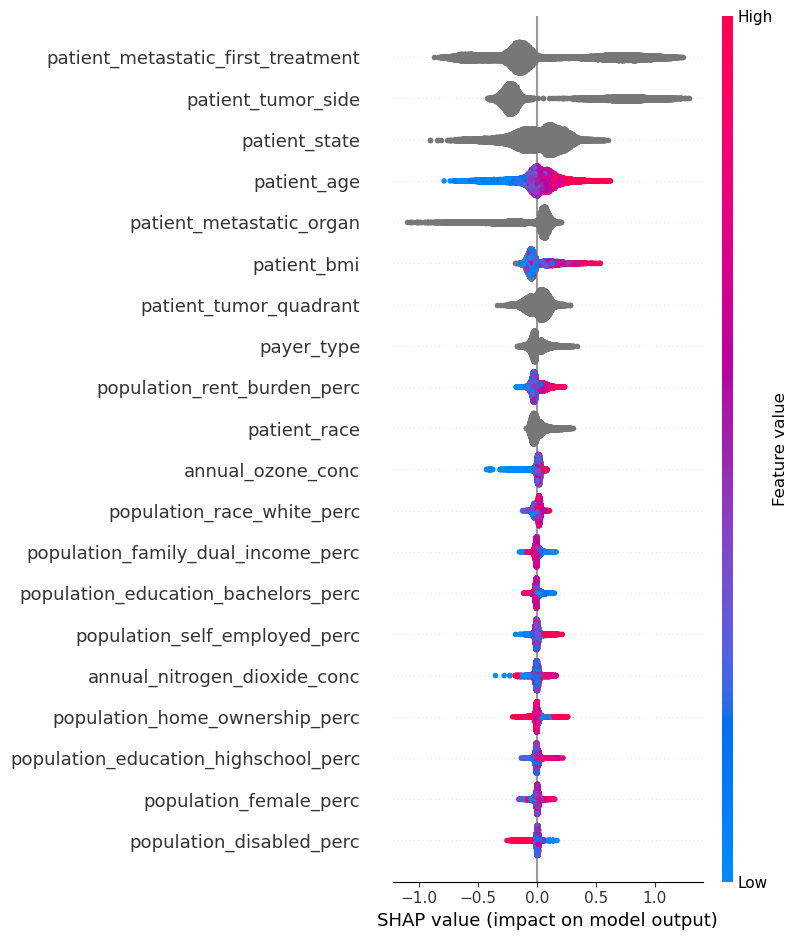

In [92]:
shap.summary_plot(shap_values, X)

In [93]:
# Ref: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
for name in X_train_30.columns:
    shap.dependence_plot(name, shap_values.values, X)

TypeError: '<' not supported between instances of 'float' and 'str'